In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn.base import BaseEstimator
import random

df = pd.read_csv(r"C:\Users\micha\Desktop\Loan Stats\LoanStats_2017.csv")


C:\Users\micha\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\micha\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = df[df['application_type']=='Individual'] #Isolate for Individual applicants because of the conflating factors associated 
#with joint filing
df.head()
df = df[df['term'] ==" 36 months"] #filter for only 36 months
df.count()
cols_to_keep = ['funded_amnt_inv',"int_rate","grade","sub_grade",'home_ownership','annual_inc','issue_d',"loan_status",'purpose',
"addr_state",'dti','delinq_2yrs','revol_bal','total_acc',"pub_rec_bankruptcies",
"total_il_high_credit_limit"]
data = df[cols_to_keep]
data.int_rate = pd.Series(data.int_rate).str.replace('%', '').astype(float)
data.loan_status.unique()

C:\Users\micha\Anaconda2\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


array(['Current', 'Late (31-120 days)', 'Fully Paid', 'In Grace Period',
       'Charged Off', 'Late (16-30 days)'], dtype=object)

In [5]:
data.loan_status = pd.Series(data.loan_status).replace("Current",0)
data.loan_status = pd.Series(data.loan_status).replace("Fully Paid",0)
data.loan_status = pd.Series(data.loan_status).replace("Charged Off",1)
data.loan_status = pd.Series(data.loan_status).replace("Late (31-120 days)",1)
data.loan_status = pd.Series(data.loan_status).replace("Late (16-30 days)",1)
data.loan_status = pd.Series(data.loan_status).replace("In Grace Period",1)

data.loan_status.astype(int)
data = data[data['annual_inc']<10000000]

,funded_amnt_inv,int_rate,grade,sub_grade,home_ownership,annual_inc,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,revol_bal,total_acc,pub_rec_bankruptcies,total_il_high_credit_limit
10949,5000,18.06,D,D2,RENT,10999200.0,Sep-17,0,major_purchase,CA,0.07,1,534,7,0,28669
246684,10000,11.44,B,B4,MORTGAGE,61000000.0,Mar-17,0,debt_consolidation,VA,0.01,0,14413,6,0,0


In [224]:
data.describe()

,funded_amnt_inv,int_rate,annual_inc,dti,delinq_2yrs,revol_bal,total_acc,pub_rec_bankruptcies,total_il_high_credit_limit
count,223686.000000,223686.000000,2.236860e+05,223686.000000,223686.000000,2.236860e+05,223686.000000,223686.000000,2.236860e+05
mean,12074.056713,12.271436,7.832819e+04,17.825421,0.357993,1.520111e+04,22.960033,0.138337,4.285660e+04
std,8672.471309,4.633513,1.493765e+05,8.087843,0.964925,2.218537e+04,11.808113,0.383147,4.461362e+04
min,1000.000000,5.320000,3.400000e+03,0.000000,0.000000,0.000000e+00,2.000000,0.000000,0.000000e+00
25%,6000.000000,8.240000,4.500000e+04,11.690000,0.000000,5.275000e+03,14.000000,0.000000,1.490400e+04
50%,10000.000000,11.490000,6.500000e+04,17.440000,0.000000,9.953500e+03,21.000000,0.000000,3.184800e+04
75%,15825.000000,14.990000,9.300000e+04,23.810000,0.000000,1.801600e+04,29.000000,0.000000,5.709775e+04
max,40000.000000,30.990000,6.100000e+07,39.990000,42.000000,1.698749e+06,151.000000,7.000000,1.736064e+06


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223681 entries, 2 to 324929
Data columns (total 16 columns):
funded_amnt_inv               223681 non-null int64
int_rate                      223681 non-null float64
grade                         223681 non-null object
sub_grade                     223681 non-null object
home_ownership                223681 non-null object
annual_inc                    223681 non-null float64
issue_d                       223681 non-null object
loan_status                   223681 non-null int64
purpose                       223681 non-null object
addr_state                    223681 non-null object
dti                           223681 non-null float64
delinq_2yrs                   223681 non-null int64
revol_bal                     223681 non-null int64
total_acc                     223681 non-null int64
pub_rec_bankruptcies          223681 non-null int64
total_il_high_credit_limit    223681 non-null int64
dtypes: float64(3), int64(7), object(6)
memor

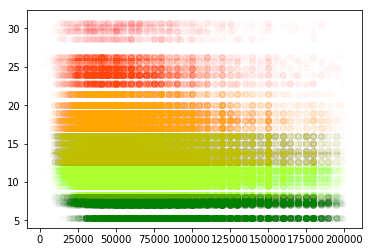

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
data_A = data[(data['annual_inc']<200000)&(data['grade']=="A")]
x = np.array(data_A['annual_inc'])
y = np.array(data_A['int_rate'])
plt.scatter(x,y,alpha=.01, c='g')

data_B = data[(data['annual_inc']<200000)&(data['grade']=="B")]
x = np.array(data_B['annual_inc'])
y = np.array(data_B['int_rate'])
plt.scatter(x,y,alpha=.01, c='greenyellow')

data_C = data[(data['annual_inc']<200000)&(data['grade']=="C")]
x = np.array(data_C['annual_inc'])
y = np.array(data_C['int_rate'])
plt.scatter(x,y,alpha=.01,c='y')

data_D = data[(data['annual_inc']<200000)&(data['grade']=="D")]
x = np.array(data_D['annual_inc'])
y = np.array(data_D['int_rate'])
plt.scatter(x,y,alpha=.01,c='orange')


data_E = data[(data['annual_inc']<200000)&(data['grade']=="E")]
x = np.array(data_E['annual_inc'])
y = np.array(data_E['int_rate'])
plt.scatter(x,y,alpha=.01,c="orangered")

data_F = data[(data['annual_inc']<200000)&(data['grade']=="F")]
x = np.array(data_F['annual_inc'])
y = np.array(data_F['int_rate'])
plt.scatter(x,y,alpha=.01,c='red')

In [14]:
x = np.array(data['grade'])
y = np.array(data['int_rate'])
plt.hist(x,y)

NameError: name 'plt' is not defined

In [245]:
x = np.array(data['income'])
y = np.array(data['funded_amnt'])

AttributeError: 'numpy.float64' object has no attribute 'drop'

In [28]:
d = data[(data['grade']=="D")&(data['loan_status']==0)]
len(d)


21564